<a href="https://colab.research.google.com/github/roysa-msft/tech-train-reusable-modules/blob/main/Linear_Models_Ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import  matplotlib.pyplot as plt

%matplotlib inline

# Introduction

For this exercise we will use an open dataset from Kaggle, which contains results from a Customer Satisfaction survey from a specific airline.

The dataset itself, as well its description, is available here: https://www.kaggle.com/datasets/yakhyojon/customer-satisfaction-in-airline

Today we will train a Logistic Regression model (from the package `sklearn`) for a binary classification task. The task is to predict customer's satisfaction (1=satisfied, 0=not_satisfied) based on other features available in the table.

We begin with the following elementary steps:

1. Download the dataset and keep it in a place accessible for your notebook.
1. Load it into memory with `pd.read_csv()`. Refer to the public Pandas API for help.
1. Examine basic information about the dataframe: its size, number of column (and their names). Are there Nones (how many)?

In [5]:
df = pd.read_csv(r"Invistico_Airline.csv")

In [6]:
df.columns

Index(['satisfaction', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient',
       'Food and drink', 'Gate location', 'Inflight wifi service',
       'Inflight entertainment', 'Online support', 'Ease of Online booking',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes'],
      dtype='object')

In [15]:
df.isna().sum().sum()
df.head(10).T
#df['satisfaction'].unique() # map({'satisfied': 1, 'dissatisfied': 0})


,0,1,2,3,4,5,6,7,8,9
satisfaction,satisfied,satisfied,satisfied,satisfied,satisfied,satisfied,satisfied,satisfied,satisfied,satisfied
Customer Type,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer
Age,65,47,15,60,70,30,66,10,56,22
Type of Travel,Personal Travel,Personal Travel,Personal Travel,Personal Travel,Personal Travel,Personal Travel,Personal Travel,Personal Travel,Personal Travel,Personal Travel
Class,Eco,Business,Eco,Eco,Eco,Eco,Eco,Eco,Business,Eco
Flight Distance,265,2464,2138,623,354,1894,227,1812,73,1556
Seat comfort,0,0,0,0,0,0,0,0,0,0
Departure/Arrival time convenient,0,0,0,0,0,0,0,0,0,0
Food and drink,0,0,0,0,0,0,0,0,0,0
Gate location,2,3,3,3,3,3,3,3,3,3


# Preprocessing
We need to encode non-numerical variables (i.e. columns) into numbers. One popular variable type is the categorical variable: a variable with a fixed number of possible values (in programming this is usually called an Enum).

There are various ways to encode such variables, the one which we will use is boolean-expansion. Formally, suppose the Enum has $k$ values $\{v_1,...,v_k\}$, and its column name is `my_enum` replace that column with $k$ new columns. For each row of `my_enum`: if the value was $v_i$ put $1$ in the $i$-th column and zero on the others.

In addition, you need to account for missing values ("imputation"). There are many possible ways, and there is no "correct" answer here. If the data is numerical you can fill it with its mean, default value (domain specific) or even train a regression model using other columns to predict that column (and uses the predictions to fill empty cells of that column).

Make sure to preprocess the dataset to contains only numerical values. In addition, encode the prediction target (i.e. the `satisfaction` column) to be $1$ for `satisfied` and $0$ otherwise.

### The goal of this step

Ultimately, we aim to end this section with two global python variables:
* `features` - a pandas DataFrame which contains all the feature columns (after the processing). Note that the label column should NOT be in this dataframe
* `labels` - a pandas Series of type `int` which contains the corresponding labels of rows from the `features` dataframe

In [24]:
features = (
    df.drop(columns=['satisfaction'])
    .assign(Class_Eco = df['Class'].map({'Eco': 1, 'Eco Plus': 0, 'Business': 0}))
    .assign(Class_Eco_Plus = df['Class'].map({'Eco': 0, 'Eco Plus': 1, 'Business': 0}))
    .assign(Class_Business = df['Class'].map({'Eco': 0, 'Eco Plus': 0, 'Business': 1}))
    .drop(columns=['Class'])
    .assign(Customer_Type_Loyal_Customer = df['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0}))
    .assign(Customer_Type_disloyal_Customer = df['Customer Type'].map({'Loyal Customer': 0, 'disloyal Customer': 1}))
    .drop(columns=['Customer Type'])
    .assign(Type_of_Travel_Business_travel = df['Type of Travel'].map({'Business travel': 1, 'Personal Travel': 0}))
    .assign(Type_of_Travel_Personal_Travel = df['Type of Travel'].map({'Business travel': 0, 'Personal Travel': 1}))
    .drop(columns=['Type of Travel'])
    .assign(Age = df['Age'].fillna(df['Age'].mean()))
    .assign(**{'Flight Distance': lambda x: x['Flight Distance'].fillna(x['Flight Distance'].mean())})
    .assign(**{'Seat comfort': lambda x: x['Seat comfort'].fillna(x['Seat comfort'].mean())})
    .assign(**{'Departure/Arrival time convenient': lambda x: x['Departure/Arrival time convenient'].fillna(x['Departure/Arrival time convenient'].mean())})
    .assign(**{'Food and drink': lambda x: x['Food and drink'].fillna(x['Food and drink'].mean())})
    .assign(**{'Gate location': lambda x: x['Gate location'].fillna(x['Gate location'].mean())})
    .assign(**{'Inflight wifi service': lambda x: x['Inflight wifi service'].fillna(x['Inflight wifi service'].mean())})
    .assign(**{'Inflight entertainment': lambda x: x['Inflight entertainment'].fillna(x['Inflight entertainment'].mean())})
    .assign(**{'Online support': lambda x: x['Online support'].fillna(x['Online support'].mean())})
    .assign(**{'Ease of Online booking': lambda x: x['Ease of Online booking'].fillna(x['Ease of Online booking'].mean())})
    .assign(**{'On-board service': lambda x: x['On-board service'].fillna(x['On-board service'].mean())})
    .assign(**{'Leg room service': lambda x: x['Leg room service'].fillna(x['Leg room service'].mean())})
    .assign(**{'Baggage handling': lambda x: x['Baggage handling'].fillna(x['Baggage handling'].mean())})
    .assign(**{'Checkin service': lambda x: x['Checkin service'].fillna(x['Checkin service'].mean())})
    .assign(**{'Cleanliness': lambda x: x['Cleanliness'].fillna(x['Cleanliness'].mean())})
    .assign(**{'Departure Delay in Minutes': lambda x: x['Departure Delay in Minutes'].fillna(x['Departure Delay in Minutes'].median())})
    .assign(**{'Arrival Delay in Minutes': lambda x: x['Arrival Delay in Minutes'].fillna(x['Arrival Delay in Minutes'].median())})
)
labels = (
    df['satisfaction'].map({'satisfied': 1, 'dissatisfied': 0})
).astype(int)

features.head(10).T

,0,1,2,3,4,5,6,7,8,9
Age,65.0,47.0,15.0,60.0,70.0,30.0,66.0,10.0,56.0,22.0
Flight Distance,265.0,2464.0,2138.0,623.0,354.0,1894.0,227.0,1812.0,73.0,1556.0
Seat comfort,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Departure/Arrival time convenient,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Food and drink,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gate location,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
Inflight wifi service,2.0,0.0,2.0,3.0,4.0,2.0,2.0,2.0,5.0,2.0
Inflight entertainment,4.0,2.0,0.0,4.0,3.0,0.0,5.0,0.0,3.0,0.0
Online support,2.0,2.0,2.0,3.0,4.0,2.0,5.0,2.0,5.0,2.0
Ease of Online booking,3.0,3.0,2.0,1.0,2.0,2.0,5.0,2.0,4.0,2.0


In [ ]:
# I keep here an example of how the output of `features.head(3).T` should looks like

,0,1,2
Age,65.0,47.0,15.0
Flight Distance,265.0,2464.0,2138.0
Seat comfort,0.0,0.0,0.0
Departure/Arrival time convenient,0.0,0.0,0.0
Food and drink,0.0,0.0,0.0
Gate location,2.0,3.0,3.0
Inflight wifi service,2.0,0.0,2.0
Inflight entertainment,4.0,2.0,0.0
Online support,2.0,2.0,2.0
Ease of Online booking,3.0,3.0,2.0


Here we split the dataset into train and test, via a random split, using the proportions of 66% of the data for training.

Do not change this section, just run it as it is (safe to run multiple times).

In [25]:
np.random.seed(1234)
is_train_mask = np.random.permutation(len(features)) < (len(df) * 0.66)

# Fit a Logistic Regression model

As most of the model inside the `sklearn` package, we instantiate a class of specific ML algorithm (e.g. `model=LogisticRegression(**hyper_params)`) then we call its `model.fit(features, labels)` method to train it. Then we generate predictions using the trained model by calling `model.predict_proba(features)`. Note that `features` is a table (e.g. pandas-DataFrame) where each row is a sample of the data and each column is a specific variable (a.k.a "feature"). `lables` is a vector (e.g. pandas-Series) of zero-one, indicating the class of each row in `features`.

For the next step, you are requested to instantiate a `LogisticRegression` instance from `sklearn.linear_model`, and configure its parameters. The parameters of interest are:
* `penalty`: string indicating the type of regularization to use: `elasticnet` `l1` `l2` `none`
* `l1_raio`: mix between $\ell_1$ and $\ell_2$ regularizations, ignored when not relevant (depends on `penalty`)
* `C`: regularization coefficient, use number close to $1$ for strong regularization, close to $0$ for low or none regularization.
* `solver`: different algorithm have different advantages. Unfortunately, not all of them works with all type of regularizations. One way is to fix that parameter on `"saga"` algorithm which supports both `l1` and `l2` and their mix. Another way is to use specific algorithm to the penalty we use, for example `"lbfgs"` for `l2` and `"liblinear"` for `l1`. You are encourage to try and see the differences.

For this exercise, fix the following values for the Logistic Regression: `max_iter=200` and `n_jobs=-1`.

You can read more about the parameters and API of that class in: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


Note that `model.predict_proba()` returns a matrix of shape `[len(data), 2]`. Where the first column holding the probability for class `0`, while the second columns is for class `1`. Since we are in the binary case, we are interested in cases of predicting "satisfied", therefore use the following:  
`predictions = model.predict_proba(dataset)[:, 1]`

Pandas Tip:
You can use `features.loc[is_train_mask]` and `labels.loc[is_train_mask])` to refer to the **Train** set, and `features.loc[~is_train_mask]` and `labels.loc[~is_train_mask])` for the **Test** set.

In [26]:
features.shape

(129880, 25)

In [35]:
# create a model. call its "fit(...)" method, and then generate predictions using `preds = model.predict_proba(features)[:, 1]`
hyper_params = {
    'penalty': 'l2',
    'l1_ratio': None,
    'C': 0.1,
    'solver': 'saga',
    'max_iter': 200,
    'n_jobs': -1
}
model=LogisticRegression(**hyper_params)
model.fit(features.loc[is_train_mask], labels.loc[is_train_mask])
predictions = model.predict_proba(features)[:, 1]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Inspect the quality of the model

We want the model to be able to predict the training data with high quality, and at the same time, we want the quality over the train dataset to be as close as possible to the quality over the test dataset.

Use `plot_stats_and_get_auc()` which is implemented below, to display the **AUC curve** of your model on a given train\test set. The function also returns the AUC score as a float. In the next paragraph we describe what AUC is. You will use the plot and the numerical score to evaluate your model, once over the training-set and once over the test-set.

The goal is to have both scores close to each other. You'll probably have to adjust the learning parameters of the algorithm and retrain the model to achieve this.

_Side question - what is the implication of a large gap between the test and train scores?_

#### What's AUC?

In the class we discussed the confusion matrix and few numerical statistics which can be computed out of it, in order to estimate binary classification. All these metrics applied over binary predictions (e.g. either $0$ or $1$), however, the model outputs **probabilities** (i.e. floats in between). We said in class that usually we apply a rounding by some threshold $\theta$ in order to convert probability to a zero-one prediction.

This exercise we will use a different metric:

To evaluate the quality of the model as a single number we will use the `AUC` metric, which is an elegant way to capture the prediction power of the model for many rounding thresholds!

Here is a 2min read about AUC: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

Here is a 5min read with slightly more examples: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

The Official `sklean` package also have a good explanation: https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics

In [28]:
# Use this function to plot the AUC curve and its value
def plot_stats_and_get_auc(y_scores, y_true):
    plt.figure(figsize=(11,8))
    fpr, tpr, _ = roc_curve(y_true,  y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    return auc

Train curve


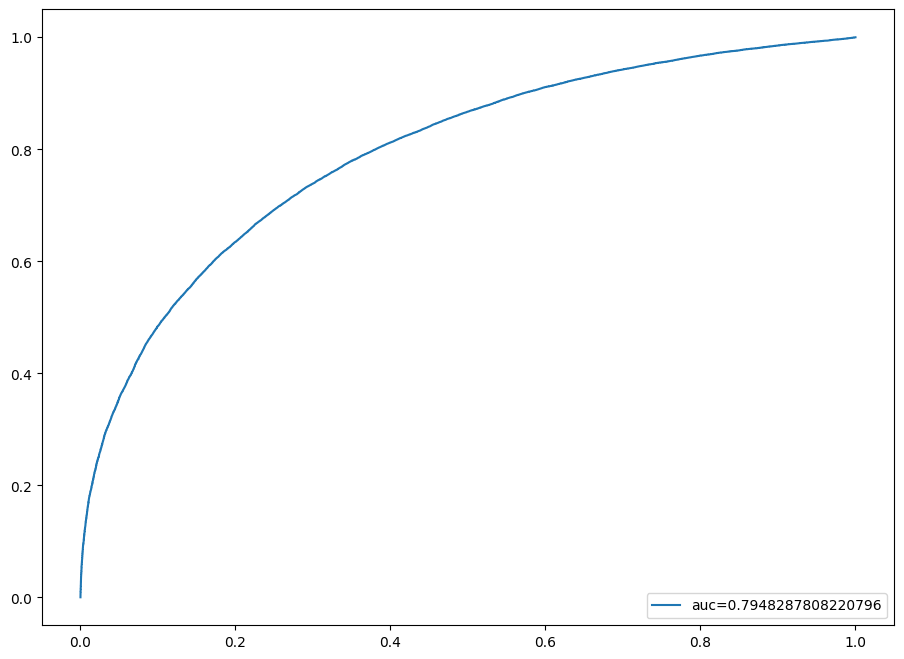

0.7948287808220796

In [36]:
print('Train curve')
# use the plot function with the training data. One way to do this is by `plot_stats_and_get_auc(preds[is_train_mask], labels[is_train_mask])`
plot_stats_and_get_auc(predictions[is_train_mask], labels[is_train_mask])
# CODE HERE

Test curve


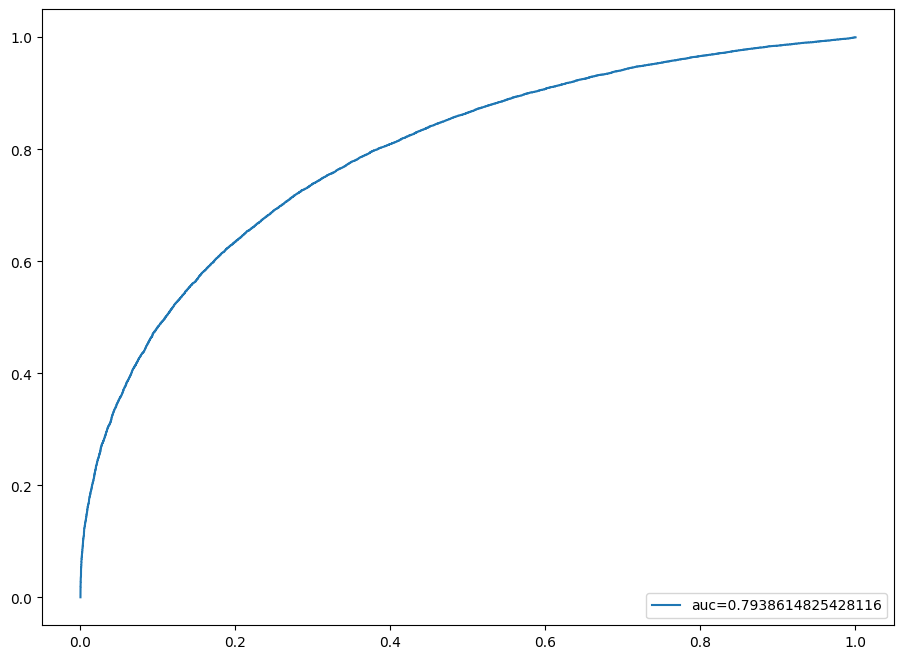

0.7938614825428116

In [37]:
print('Test curve')
plot_stats_and_get_auc(predictions[~is_train_mask], labels[~is_train_mask])

# CODE HERE

If you've used a different solver than "saga", please try to change the solver to "saga" and repeat the experiment. What have you noticed?

# Optimizing the hyper-parameters

Which penalty is best in our case? `l1`? `l2`? `elasticnet`? with which regularization coefficient?

This section you are asked to implement 2-folds cross validation and evaluate many combinations in order to find the best model's hyper-parameters.

Instructions:
* Split the dataset 50%-50% and alternate the roles between train and test
* Use the AUC metric for model quality. Note that after run the two folds with parameters-set $\omega$, the quality is the average of AUC from both folds.
* Examine all possible combinations between the following:
  - `penalty` of either `"l1"` or `"l2"`, `None` (for `None` there is no need to try different $C$ values)
  - $C\in\{1.0, 0.5, 0.1, 0.01\}$
* Keep the following parameters fixed: `max_iter=400` and `n_jobs=-1`
* For penalty `l1` use `solver='liblinear'`, otherwise use `'lbfgs'`

Print the results from all the different folds, in decreasing quality (e.g. decreasing AUC). What can you deduce from that ordering about the data?

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


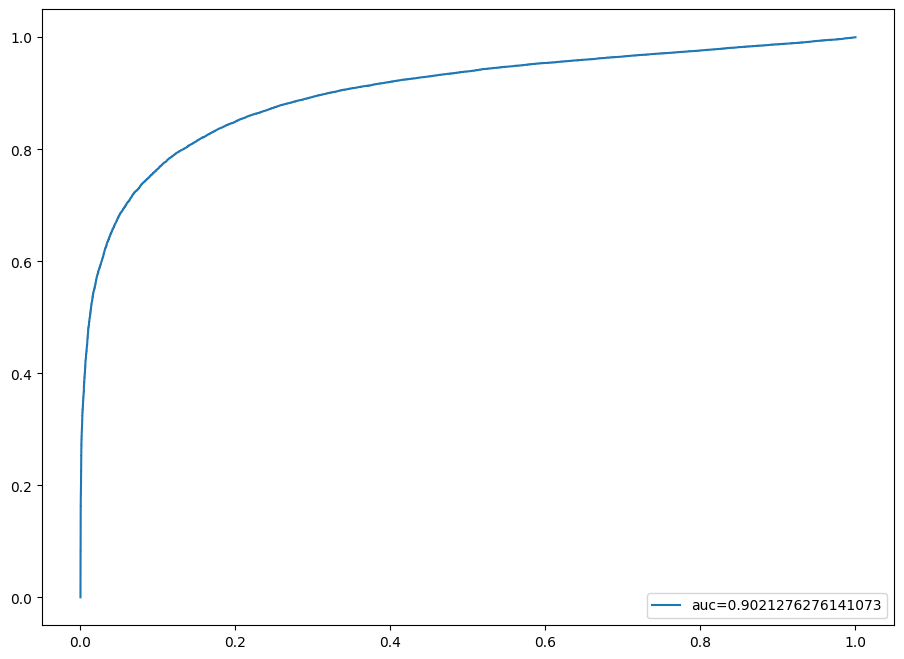

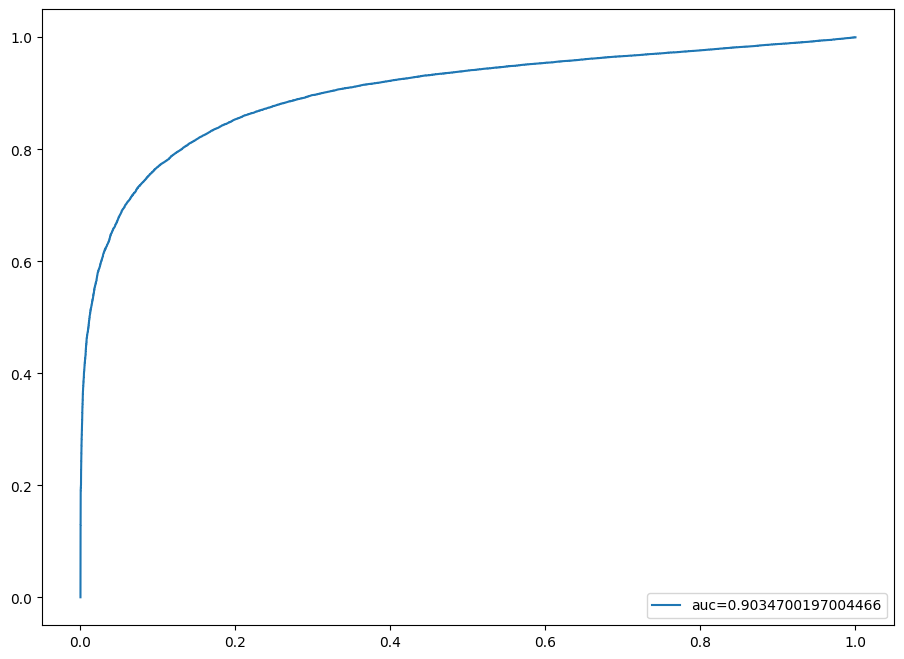

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


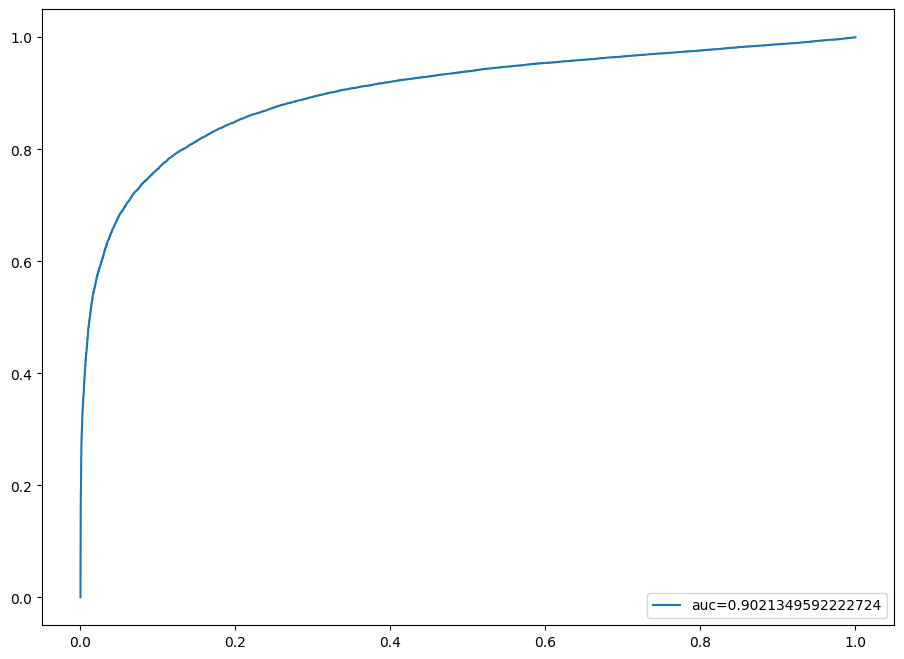

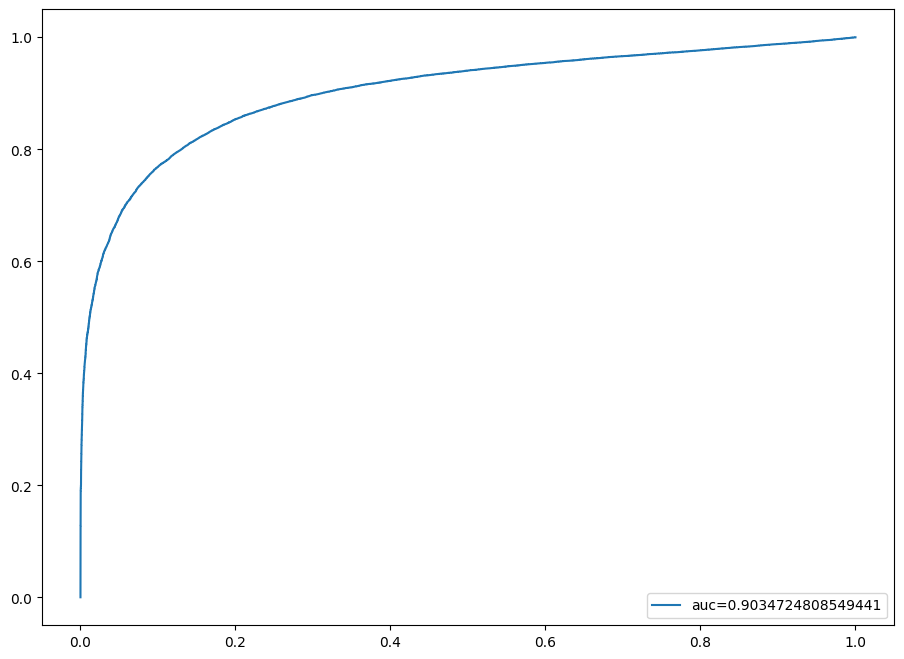

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


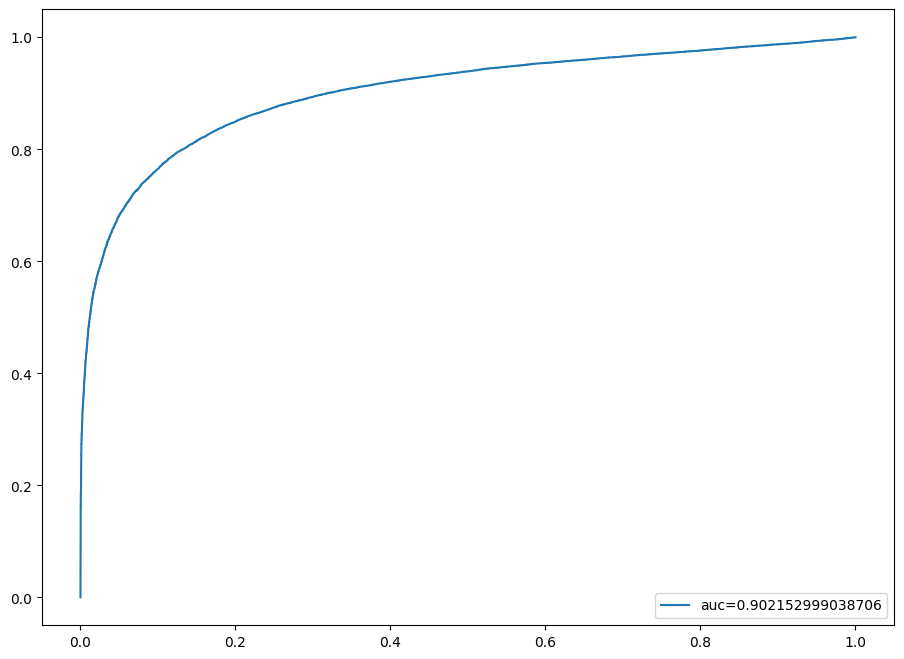

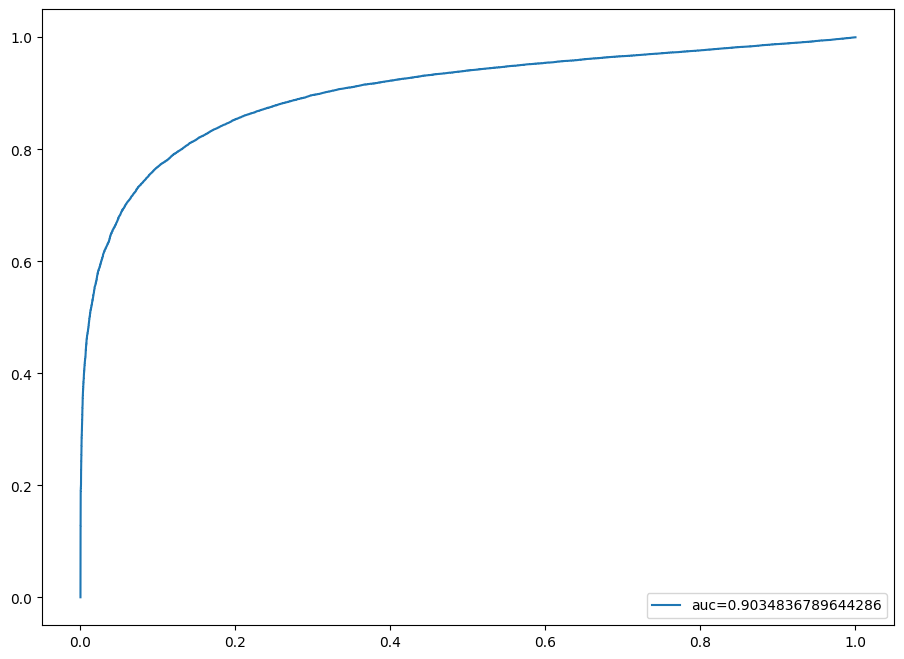

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


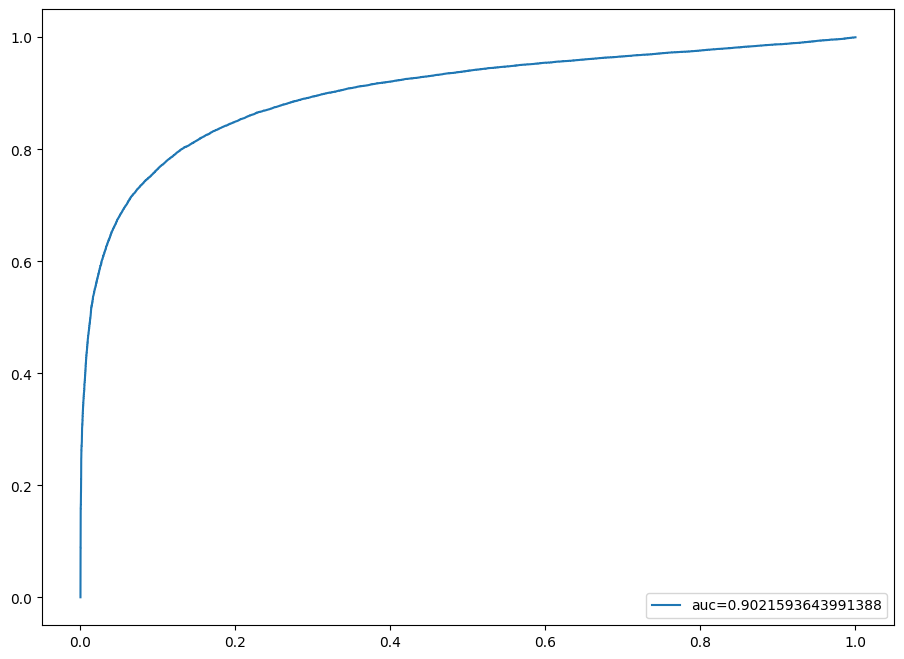

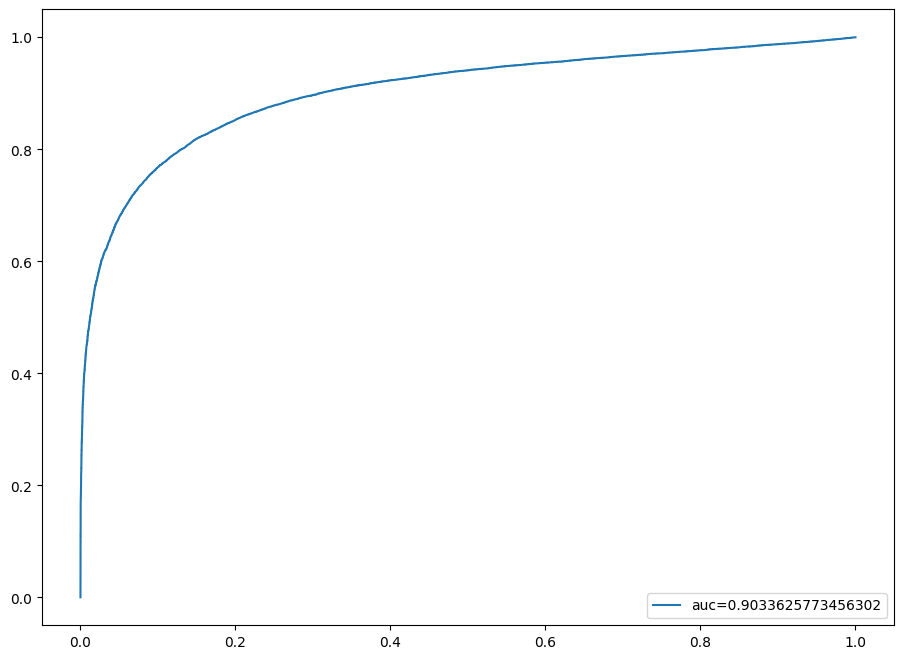

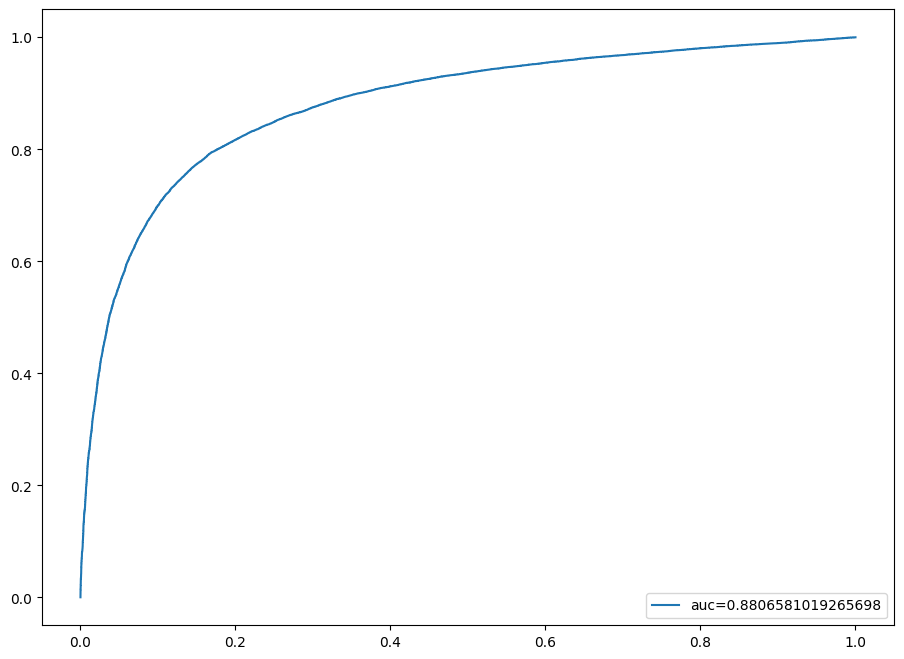

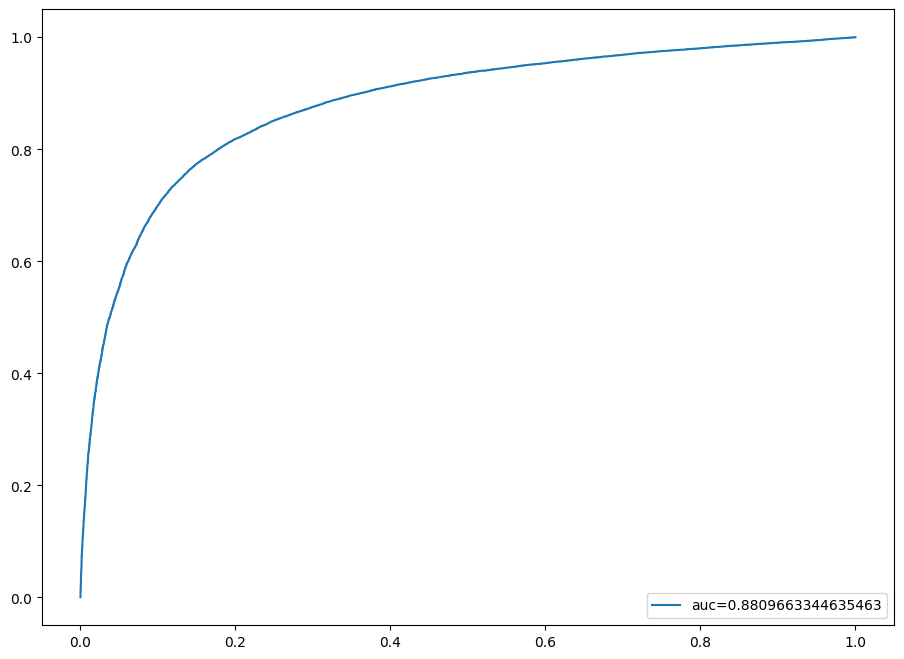

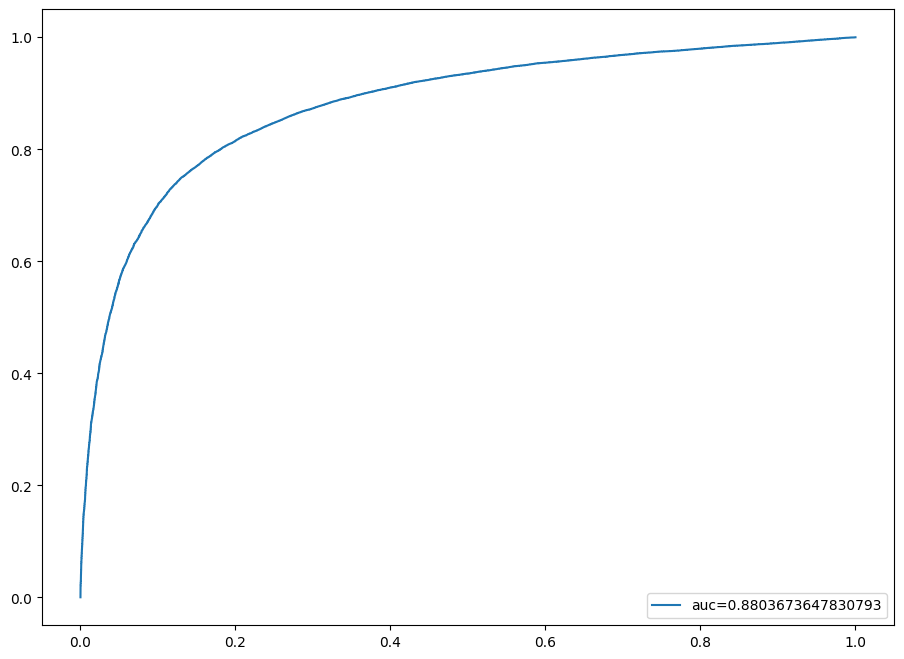

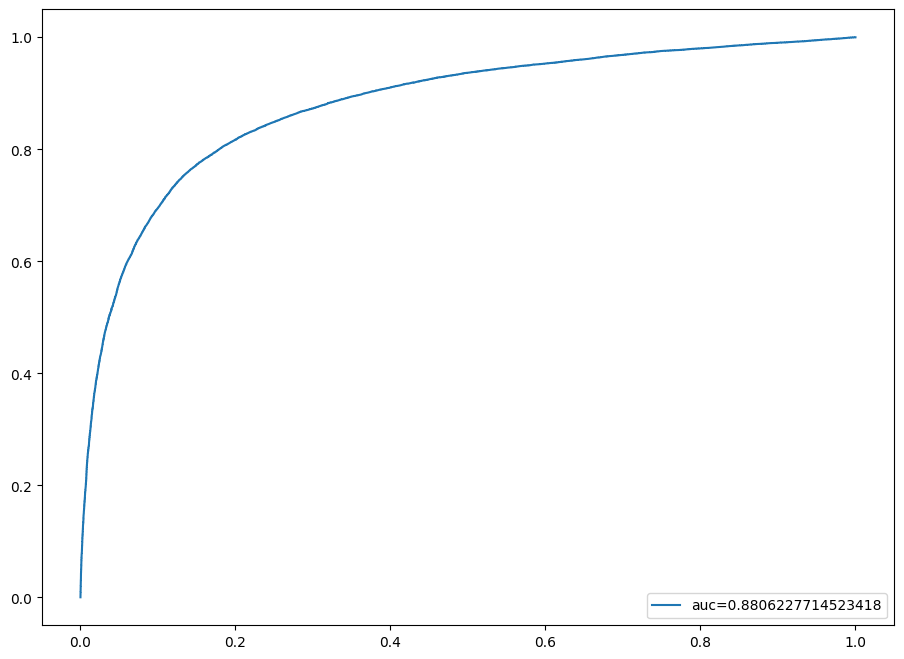

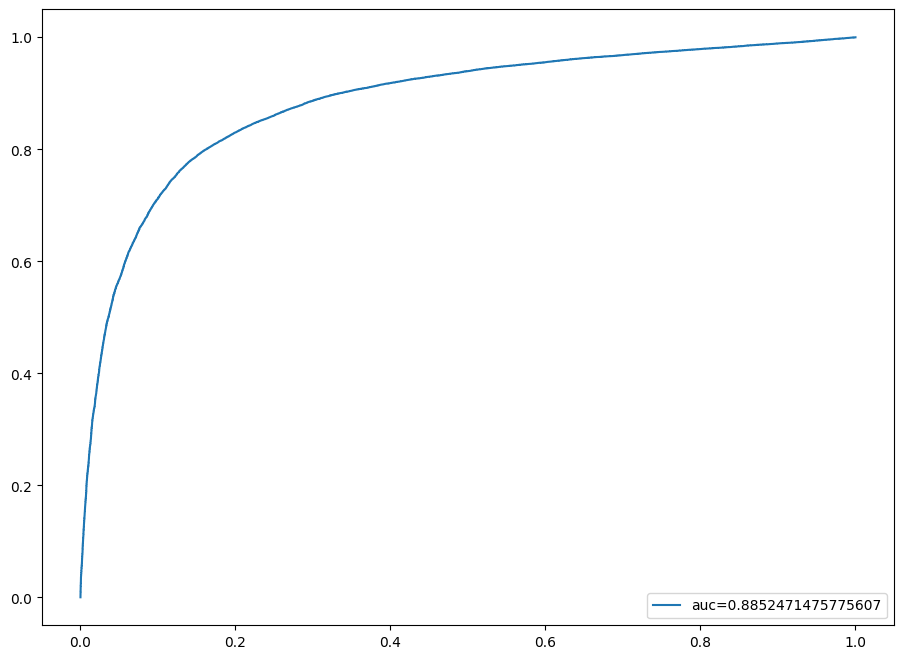

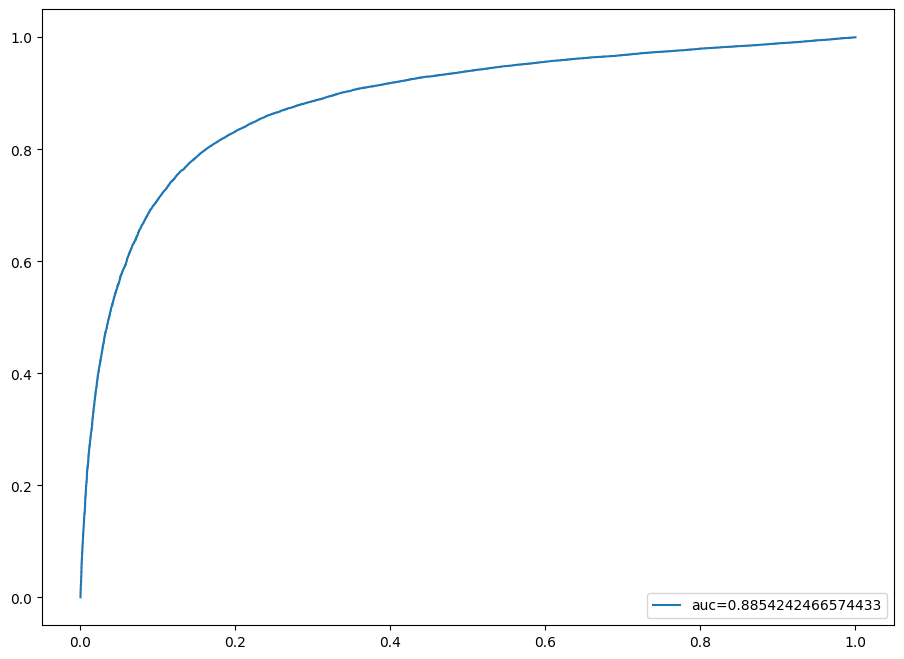

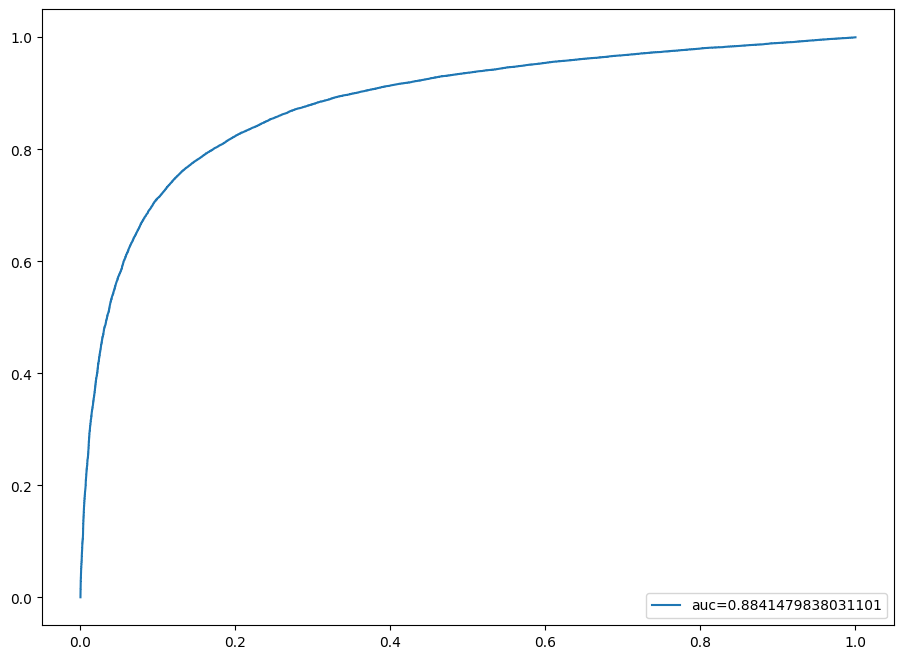

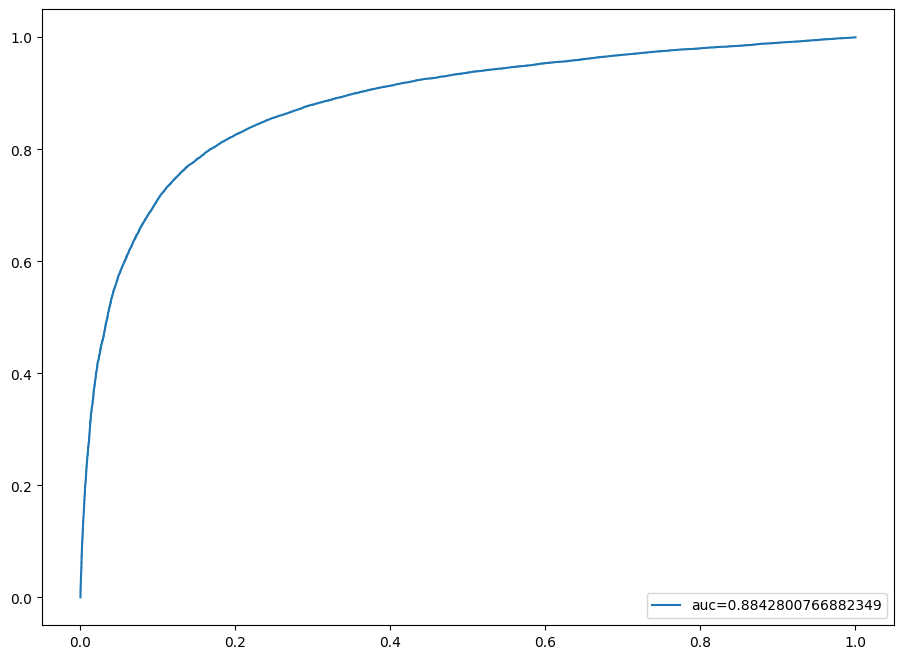

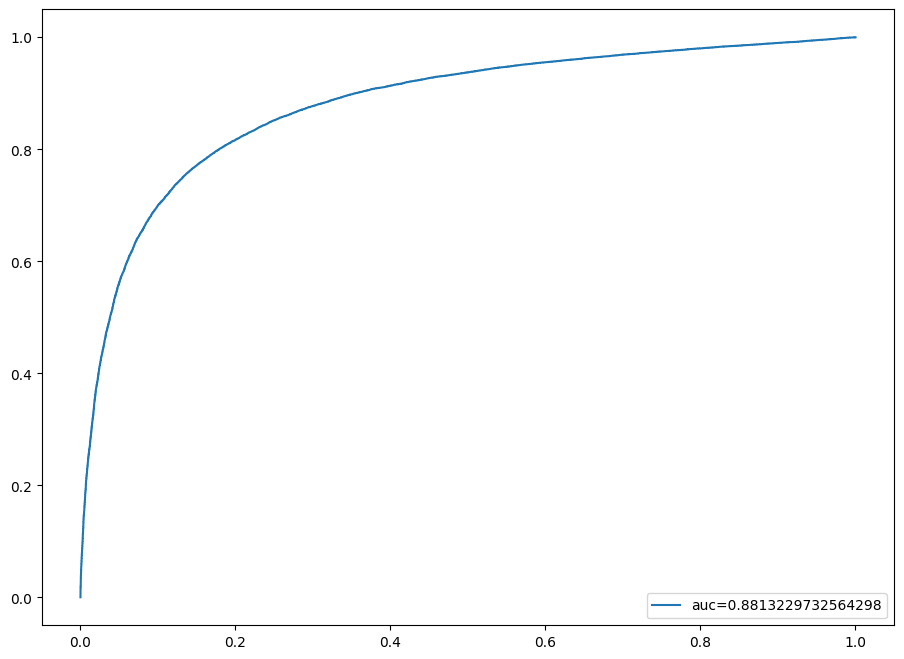

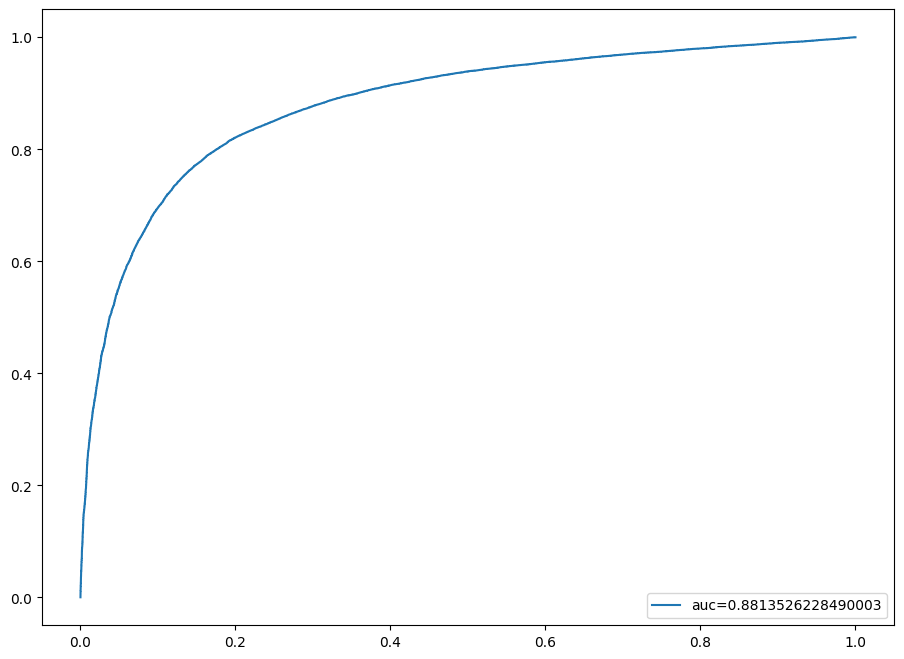

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


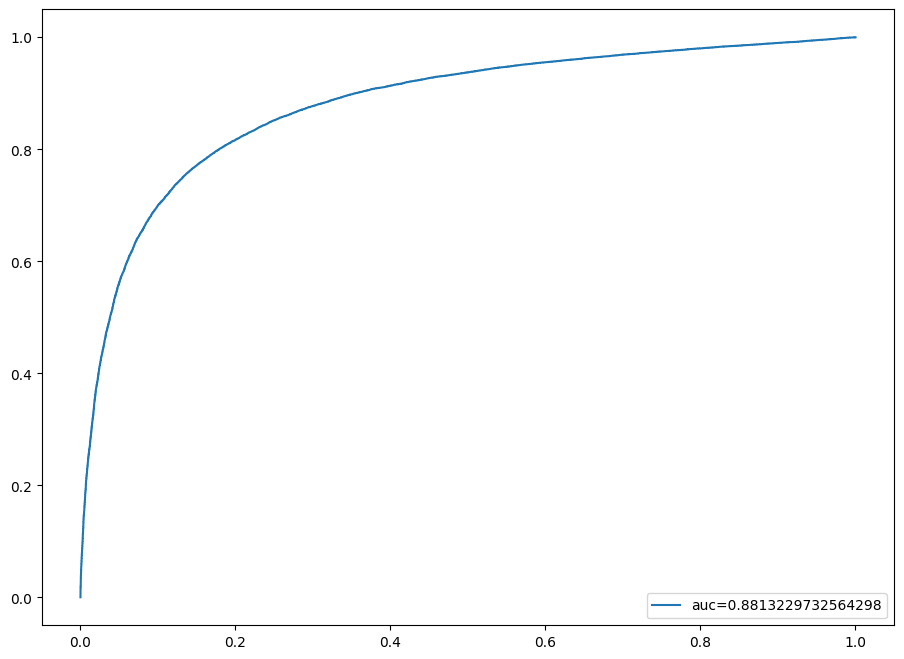

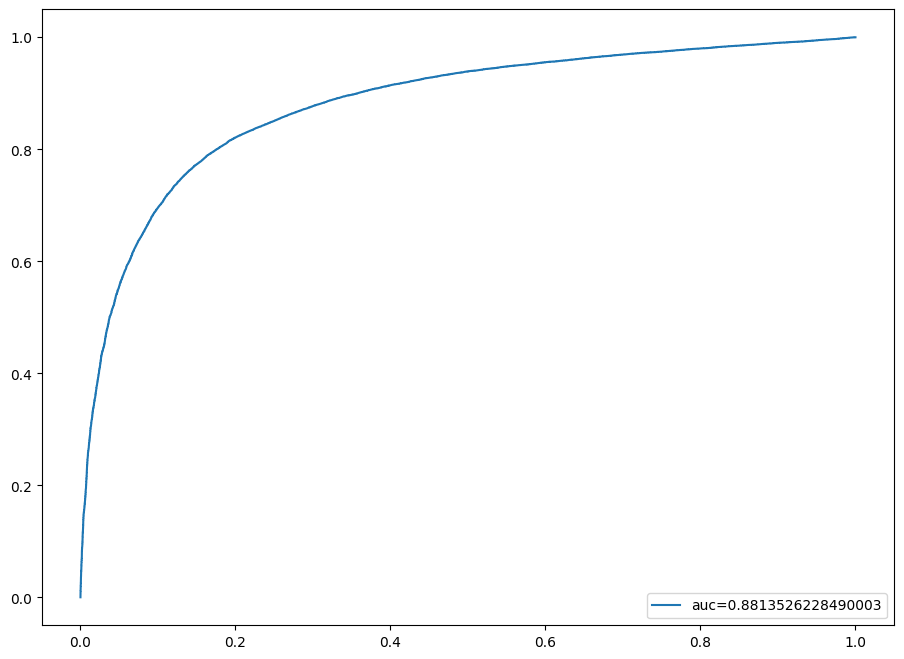

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


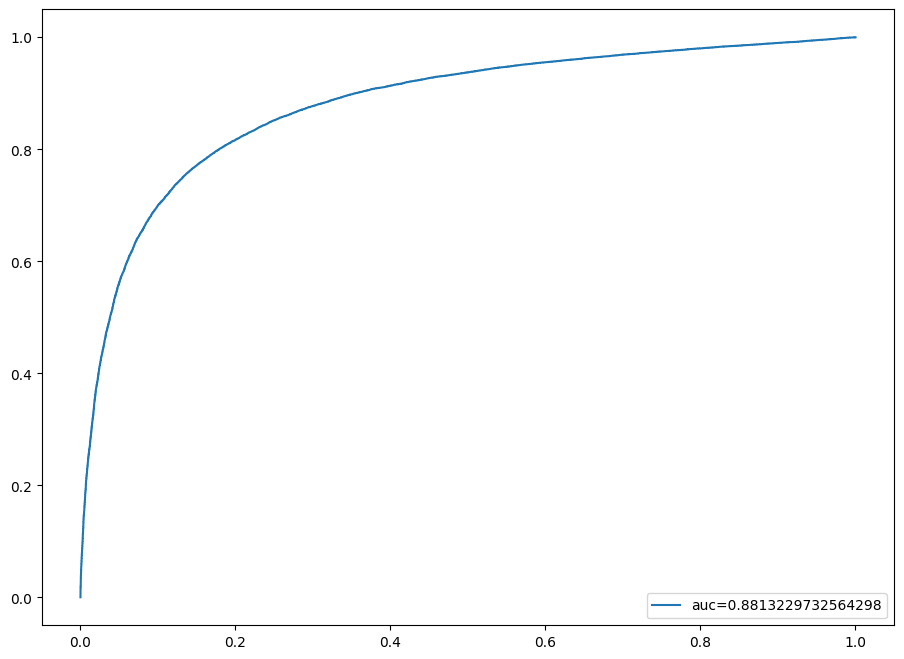

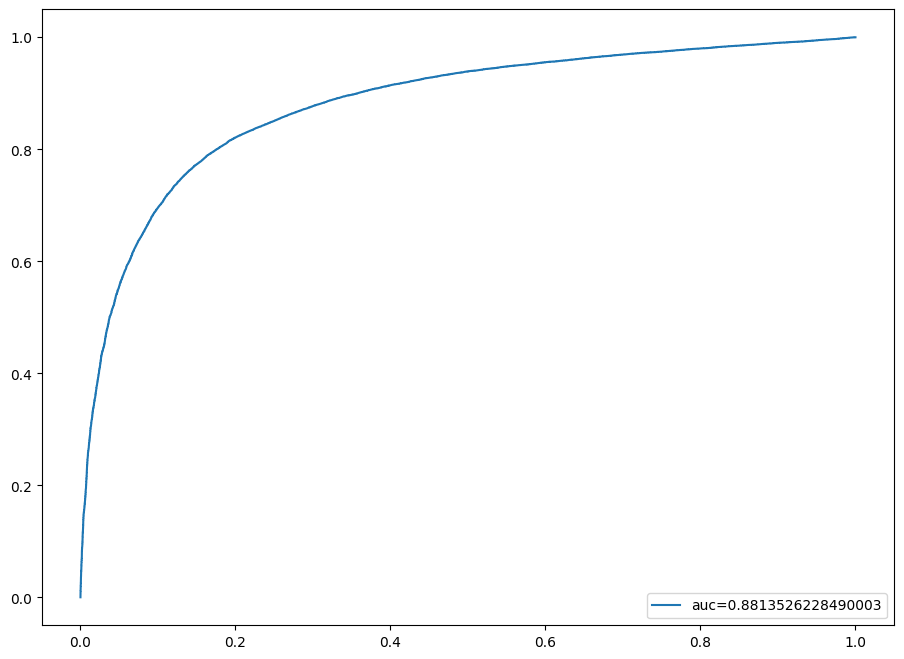

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


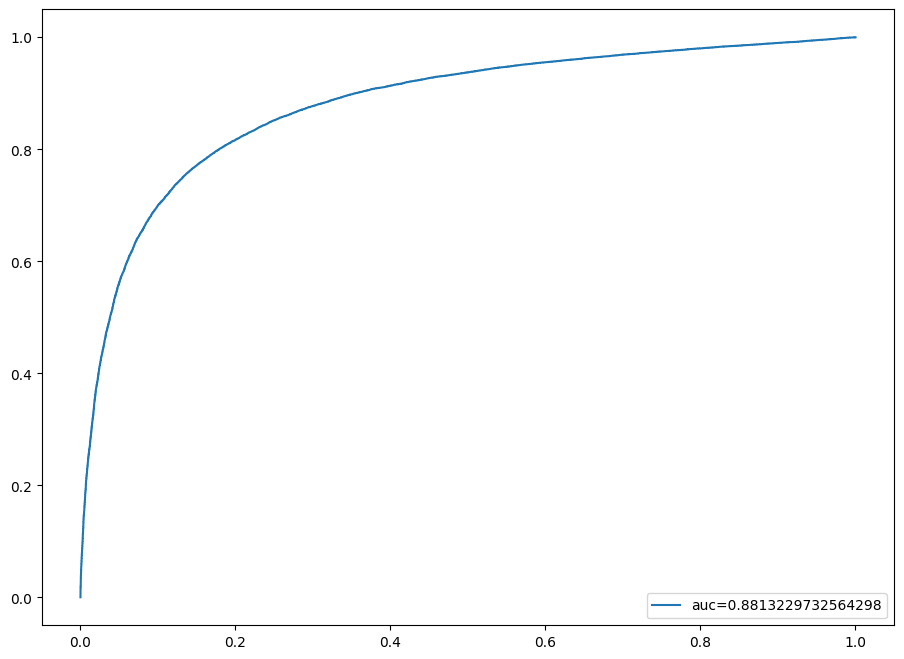

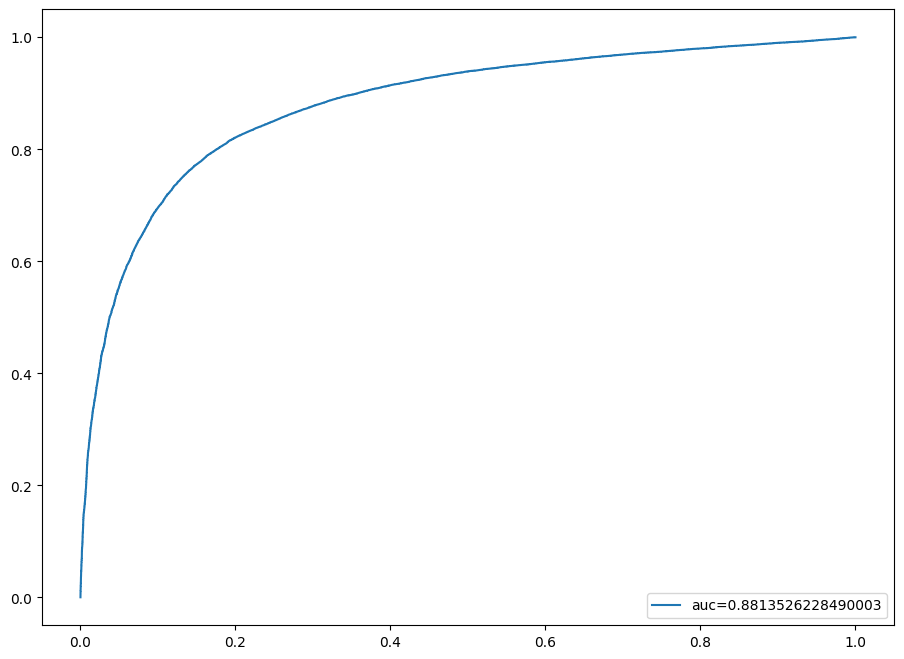

{'l1_0.1': 0.9028183390015674,
 'l1_0.5': 0.9028037200386083,
 'l1_1.0': 0.9027988236572769,
 'l1_0.01': 0.9027609708723845,
 'l2_0.1': 0.885335697117502,
 'l2_0.01': 0.8842140302456725,
 'None_1.0': 0.8813377980527151,
 'None_0.5': 0.8813377980527151,
 'None_0.1': 0.8813377980527151,
 'None_0.01': 0.8813377980527151,
 'l2_1.0': 0.8808122181950581,
 'l2_0.5': 0.8804950681177106}

In [38]:
np.random.seed(1234)
is_train_mask = np.random.permutation(len(features)) < (len(df) * 0.5)
res = {}

hyper_params['max_iter'] = 400
for penalty in ['l1', 'l2', None]:
    for C in [1.0, 0.5, 0.1, 0.01]:
      hyper_params['penalty'] = penalty
      hyper_params['C'] = C
      hyper_params['solver'] = 'liblinear' if penalty == 'l1' else 'lbfgs'
      model=LogisticRegression(**hyper_params)
      model.fit(features.loc[is_train_mask], labels.loc[is_train_mask])
      predictions = model.predict_proba(features)[:, 1]
      auc1 = plot_stats_and_get_auc(predictions[~is_train_mask], labels[~is_train_mask])
      auc2 = plot_stats_and_get_auc(predictions[is_train_mask], labels[is_train_mask])
      res[f"{penalty}_{C}"] = (auc1 + auc2) / 2

res = dict(sorted(res.items(), key=lambda item: item[1], reverse=True))
res

# Most importantly, the Feature Importance!

Now that we have a winning setting. Use it to train a fresh model (using the winning parameters) over the entire dataset. This is not for generating predictions but rather, to *understand* the dataset in hand.

Once you have the train logistic regression, pair the weights of the model (i.e. `model.coef_`) with their respective feature-names. Then print the 10 strongest features *in favor* of class $1$, and the top 10 features *in favor* of class $0$. Does it make sense to you? You can refer to the dataset's description for information about the colunms: https://www.kaggle.com/datasets/yakhyojon/customer-satisfaction-in-airline

In [40]:
# Train a model using best parameters, over the entire dataset
hyper_params['penalty'] = 'l1'
hyper_params['C'] = 0.1
hyper_params['solver'] = 'liblinear'
model=LogisticRegression(**hyper_params)
model.fit(features, labels)
model.coef_

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


array([[-9.24487638e-03, -1.82044765e-04,  2.84217061e-01,
        -2.19394443e-01, -2.06368453e-01,  1.22541343e-01,
        -9.15535641e-02,  7.16650484e-01,  1.09144794e-01,
         2.50734754e-01,  3.11058942e-01,  2.36969966e-01,
         8.79564785e-02,  2.83077685e-01,  5.90700644e-02,
         1.40688850e-01,  2.32993919e-03, -7.25867865e-03,
        -1.93769923e+00, -1.98578059e+00, -1.22140641e+00,
        -1.05864615e+00, -2.94183767e+00, -1.11703509e+00,
        -1.87790479e+00]])

In [44]:
# pair the best_model.coef_[0] with the columns of the features dataframe. Take the 10 pairs with highest coefficient value
# and the 10 pairs with lowest coefficient value
feature_importance = {}
for i in range(25):
  feature_importance[features.columns[i]] = model.coef_[0][i]
  print(features.columns[i], model.coef_[0][i])

dict(sorted(feature_importance.items(), key=lambda item: item, reverse=True)[:10])



Age -0.009244876384608266
Flight Distance -0.00018204476481809955
Seat comfort 0.284217060830308
Departure/Arrival time convenient -0.21939444325948382
Food and drink -0.20636845302201795
Gate location 0.12254134340720269
Inflight wifi service -0.09155356413040228
Inflight entertainment 0.7166504841216939
Online support 0.1091447940291488
Ease of Online booking 0.25073475437826465
On-board service 0.31105894199629547
Leg room service 0.236969966179133
Baggage handling 0.08795647854158048
Checkin service 0.28307768488205626
Cleanliness 0.05907006442837222
Online boarding 0.14068884997071462
Departure Delay in Minutes 0.002329939191237229
Arrival Delay in Minutes -0.007258678654640066
Class_Eco -1.937699229181992
Class_Eco_Plus -1.9857805929953687
Class_Business -1.2214064118092527
Customer_Type_Loyal_Customer -1.0586461495400303
Customer_Type_disloyal_Customer -2.941837666324766
Type_of_Travel_Business_travel -1.1170350902101658
Type_of_Travel_Personal_Travel -1.8779047944412226


{'Type_of_Travel_Personal_Travel': -1.8779047944412226,
 'Type_of_Travel_Business_travel': -1.1170350902101658,
 'Seat comfort': 0.284217060830308,
 'Online support': 0.1091447940291488,
 'Online boarding': 0.14068884997071462,
 'On-board service': 0.31105894199629547,
 'Leg room service': 0.236969966179133,
 'Inflight wifi service': -0.09155356413040228,
 'Inflight entertainment': 0.7166504841216939,
 'Gate location': 0.12254134340720269}